# A Gentle Introduction to Convolutional Neural Networks (CNNs) with PyTorch

This notebook provides a beginner-friendly tutorial on building and training a Convolutional Neural Network (CNN) using the PyTorch library. We'll walk through the essential components of a CNN and see how they are implemented in PyTorch. 🚀

-----

## 1\. What are CNNs?

A **Convolutional Neural Network (CNN)** is a type of deep learning model that is exceptionally good at image recognition and processing. Unlike traditional neural networks that treat images as flat vectors of pixels, CNNs are designed to recognize patterns in a structured way.

The core idea is to learn **spatial hierarchies of features**, from simple ones like edges and colors to more complex shapes and textures, and eventually to full objects. This is achieved through three main operations:

1.  **Convolutional Layer**: This layer applies a **filter** (also called a **kernel**) to the input image, producing a **feature map**. The filter slides over the image, performing element-wise multiplication and summing the results. This process helps detect specific features, like edges or corners.

2.  **Activation Function (ReLU)**: After a convolution, a non-linear activation function, most commonly the **Rectified Linear Unit (ReLU)**, is applied. This function replaces all negative values in the feature map with zero, introducing non-linearity into the model.

3.  **Pooling Layer**: A pooling layer (usually **Max Pooling**) reduces the spatial dimensions (width and height) of the feature map. It does this by taking the maximum value within a small window. This down-sampling helps to reduce computational load and makes the detected features more robust to their location.

-----

## 2\. Setup and Data Loading

First, we need to import the necessary libraries and load a dataset. We'll use the famous **Fashion-MNIST** dataset, which is a great starting point for image classification. It consists of 60,000 training images and 10,000 test images of 10 different fashion items.


In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
print(torch.__version__)
print(torch.cuda.is_available()) # True if CUDA is available and correctly installed


2.8.0+cu126
True


In [4]:
# Check if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Define a transformation to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(), # Converts a PIL Image or numpy.ndarray to a PyTorch tensor.
    transforms.Normalize((0.5,), (0.5,)) # Normalizes the tensor with a mean of 0.5 and std dev of 0.5.
])

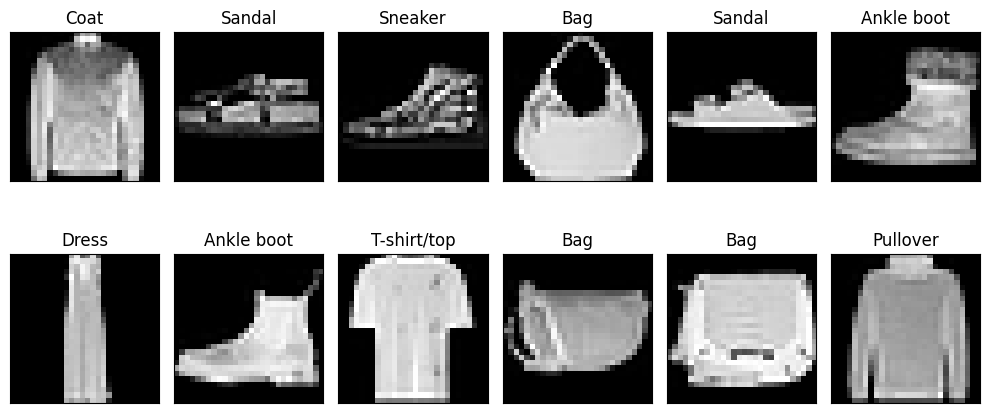

In [6]:
# Load the Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders to handle batching and shuffling
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Let's visualize some of the images from the training set
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the images
fig = plt.figure(figsize=(10, 5))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i].numpy()), cmap='gray')
    ax.set_title(class_names[labels[i].item()])
plt.tight_layout()
plt.show()

-----

## 3\. Defining the CNN Architecture

Now, we'll build our CNN model using PyTorch's `nn.Module`. Our model will consist of a few convolutional layers followed by fully connected (linear) layers for classification.

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # Fully connected layers
        # The input size to the first linear layer needs to be calculated based on the output of the conv layers
        # Original image size: 28x28
        # After conv1 and pool: (28 / 2) = 14x14
        # After conv2 and pool: (14 / 2) = 7x7
        # Number of output channels from conv2: 32
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10) # 10 is the number of classes

    def forward(self, x):
        # Apply the convolutional layers with ReLU and Max Pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 32 * 7 * 7)
        
        # Apply the fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the device (CPU/GPU)
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


-----

## 4\. Training the Model

Training a neural network involves three main steps:

1.  **Define Loss Function**: We need a way to measure how well our model is doing. For classification, we use **Cross-Entropy Loss**.
2.  **Define Optimizer**: This algorithm (e.g., **Adam**) adjusts the model's parameters (weights and biases) to minimize the loss.
3.  **The Training Loop**: We iterate through the dataset, perform a forward pass, calculate the loss, perform a backward pass to calculate gradients, and update the weights.

<!-- end list -->

In [8]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Finished Training! 🎉")

Epoch [1/5], Loss: 0.4691
Epoch [2/5], Loss: 0.3004
Epoch [3/5], Loss: 0.2575
Epoch [4/5], Loss: 0.2275
Epoch [5/5], Loss: 0.2033
Finished Training! 🎉


-----

## 5\. Evaluating the Model

Finally, let's see how well our trained model performs on the unseen test data. We'll calculate the overall accuracy.

Accuracy of the network on the 10000 test images: 90.79%


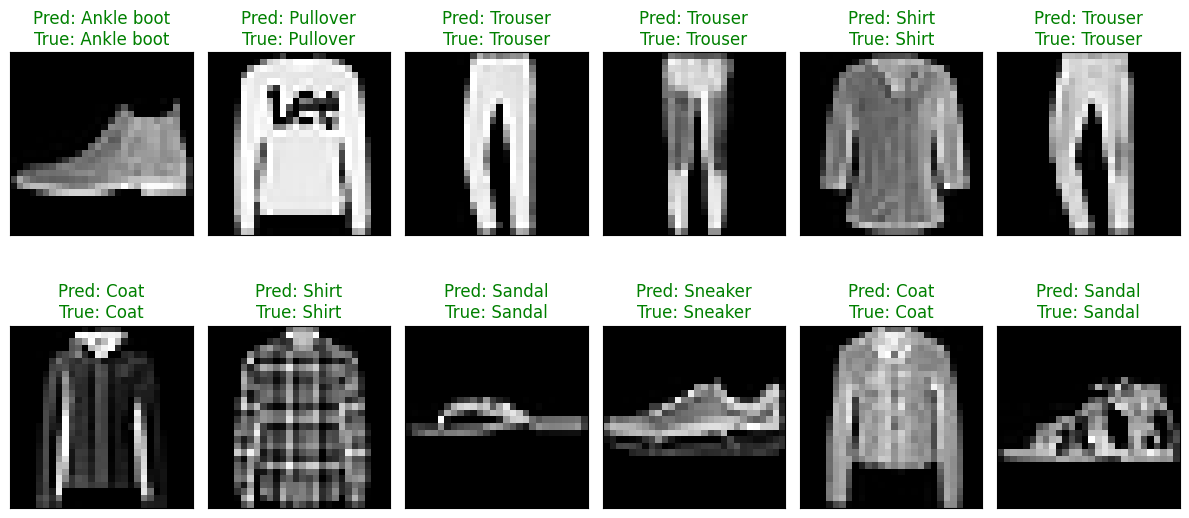

In [9]:
# Evaluate the model on the test data
model.eval() # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad(): # No need to calculate gradients during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')

# Let's visualize some predictions
# Get a batch of test data
test_images, test_labels = next(iter(test_loader))

# Make predictions
with torch.no_grad():
    model.eval()
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    test_outputs = model(test_images)
    _, test_predicted = torch.max(test_outputs.data, 1)

# Plot the images and their predictions
fig = plt.figure(figsize=(12, 6))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_images[i].cpu().numpy()), cmap='gray')
    ax.set_title(f"Pred: {class_names[test_predicted[i]]}\nTrue: {class_names[test_labels[i]]}",
                 color=("green" if test_predicted[i] == test_labels[i] else "red"))
plt.tight_layout()
plt.show()